In [163]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.manifold import TSNE
import seaborn as sns


0

In [15]:
class OrdinalEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for col in X.columns.values:
            numVals = len(X[col].unique())
            X[col] = X[col]/numVals
        return X

In [22]:
df = pd.read_csv(r'/c/Users/Andrew/Documents/Python/Pharmacy_forecast/d.csv')
x = df.iloc[:,:-1]
y = df['NoShow']


In [22]:
df.columns

Index(['PatientKey', 'PCP', 'DayOfWeek', 'HourNumber',
       'AppointmentConfirmationStatus', 'ProviderKey', 'DepartmentKey',
       'SchedulingSource', 'DepartmentSpecialty', 'PostalCode', 'VisitType',
       'Referral', 'ReferralRequired', 'LeadTime', 'Rescheduled',
       'PayorFinancialClass', 'MarkedSelfPay', 'MaritalStatus',
       'SmokingStatus', 'M', 'Diagnosis', 'Anxiety', 'Depression', 'Homeless',
       'Obesity', 'EdVisits', 'HospAdm', 'PastAppt', 'PastNoShow',
       'PastNoShowRate', 'FutureAppts', 'NoShow'],
      dtype='object')

In [23]:
numCols = ['LeadTime','EdVisits','HospAdm','PastAppt','PastNoShow','FutureAppts']
ordCols = []#'DayOfWeek','HourNumber']
oneHotCols = ['AppointmentConfirmationStatus','MaritalStatus','PayorFinancialClass','SmokingStatus', 'SchedulingSource'
                ,'DayOfWeek','HourNumber'
]
embedCols = ['ProviderKey', 'DepartmentKey', 'DepartmentSpecialty', 'PostalCode', 'VisitType', 'PatientKey']
diagCol = ['Diagnosis']
noChngCols = ['PCP','Referral','ReferralRequired','Rescheduled','MarkedSelfPay','M','PastNoShowRate'
              #, 'Anxiety'
              #,'Depression', 'Homeless', 'Obesity'
             ]

num_pipe = Pipeline([
    ('scaler',MinMaxScaler())
])

cat_pipe = Pipeline([
    ('one_hot',OneHotEncoder())
])

full_pipe = ColumnTransformer([
    ('num',num_pipe,numCols),
    ('cat',cat_pipe,oneHotCols),
    ('ord',OrdinalEncoder(),ordCols),
    ('no_change','passthrough',noChngCols)
], sparse_threshold=0)



In [24]:
cols = numCols + ordCols + oneHotCols + embedCols + diagCol + noChngCols
x_train,x_test,y_train,y_test = train_test_split(x[cols], y, random_state=123)

In [25]:
transformer = full_pipe.fit(x_train)
x_train_noEmbed = transformer.transform(x_train)
x_test_noEmbed = transformer.transform(x_test)

In [26]:
x_train_noEmbed.shape


(200046, 91)

In [27]:
encoders = []
for col in embedCols:
    encData = x_train[col]
    # test data may contain previsouly unseen labels so we need to encode an 'unseen' label
    # before tranforming test data, we replace any values we haven't seen from train data with 'unseen' label
    encData = encData.append(pd.Series('Unseen'))
    encoder = LabelEncoder().fit(encData)
    encoders.append(encoder)
    x_train[col] = encoder.transform(x_train[col])
    x_test[col] = x_test[col].apply(lambda x: x if x in encoder.classes_ else 'Unseen')
    x_test[col] = encoder.transform(x_test[col])



In [28]:
x_train_embed = x_train[embedCols]
x_test_embed = x_test[embedCols]

In [29]:
#create dict of unique diagnosis found in training data
uniqueTrainDiags = {}
for diagList in x_train['Diagnosis'].unique().tolist():
    diags = diagList.split()
    for diag in diags:
        uniqueTrainDiags[diag] = 1

In [30]:
def findUnseen(row,trainList):
    newRow = ''
    d_list = row.tolist()[0].split()
    for d in d_list:
        if trainList.get(d) is None:
            newRow += ' Unseen'
        else:
            newRow += ' ' + d
    if len(newRow) == 0:
        newRow = 'None'
    else:
        #strip leading space
        newRow = newRow[1:]
    return newRow
        

In [31]:
x_test[diagCol] = x_test[diagCol].apply(lambda x: findUnseen(x,uniqueTrainDiags), axis=1)

In [32]:
diags = x_train['Diagnosis'].tolist()
fit_diags = diags.copy()
fit_diags.append('Unseen')
maxlen=20
maxwords=1000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=maxwords)
tokenizer.fit_on_texts(fit_diags)
sequences = tokenizer.texts_to_sequences(diags)
d_index = tokenizer.word_index
d_train_data = keras.preprocessing.sequence.pad_sequences(sequences,maxlen,padding='post')
test_sequences = tokenizer.texts_to_sequences(x_test['Diagnosis'].tolist())
d_test_data = keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen,padding='post')

In [291]:
embedCols


['ProviderKey',
 'DepartmentKey',
 'DepartmentSpecialty',
 'PostalCode',
 'VisitType']

In [179]:
main_input = keras.Input(shape = x_train_noEmbed.shape[1], name = 'main_input')

diagnosis_input = keras.Input(shape = d_train_data.shape[1], name = 'diagnosis_input' )
d = keras.layers.Embedding(output_dim = 8, input_dim=maxwords, input_length = maxlen)(diagnosis_input)
diagnosis_out = keras.layers.Flatten()(d)
diagnosis_output = keras.layers.Dense(1, activation='sigmoid', name = 'diagnosis_model_out')(diagnosis_out)

Prov = keras.Input(shape =(1,), name = 'provider')
p = keras.layers.Embedding(output_dim = 4, input_dim = len(x_train['ProviderKey'].unique())+1, input_length = 1
                              )(Prov)
pout = keras.layers.Flatten()(p) 

Dep = keras.Input(shape =(1,), name = 'dep')
dd = keras.layers.Embedding(output_dim = 4, input_dim = len(x_train['DepartmentKey'].unique())+1, input_length = 1
                              )(Dep)
ddout = keras.layers.Flatten()(dd) 

Spec = keras.Input(shape =(1,), name = 'specialty')
sp = keras.layers.Embedding(output_dim = 2, input_dim = len(x_train['DepartmentSpecialty'].unique())+1, input_length = 1
                              )(Spec)
spout = keras.layers.Flatten()(sp) 

Zip = keras.Input(shape =(1,), name = 'zipcode')
z = keras.layers.Embedding(output_dim = 2, input_dim = len(x_train['PostalCode'].unique())+1, input_length = 1
                              )(Zip)
zout = keras.layers.Flatten()(z) 

Vis = keras.Input(shape =(1,), name = 'visit')
v = keras.layers.Embedding(output_dim = 4, input_dim = len(x_train['VisitType'].unique())+1, input_length = 1
                              )(Vis)
vout = keras.layers.Flatten()(v) 

#Pat = keras.Input(shape =(1,), name = 'patient')
#pp = keras.layers.Embedding(output_dim = 2, input_dim = len(x_train['PatientKey'].unique())+1, input_length = 1
#                              )(Pat)
#patout = keras.layers.Flatten()(pp)


full = keras.layers.concatenate([main_input, diagnosis_out, pout, ddout, spout, zout, vout])
full = keras.layers.Dense(200, activation = 'relu')(full)
full = keras.layers.Dropout(0.5)(full)
full = keras.layers.Dense(200, activation = 'relu')(full)
full = keras.layers.Dropout(0.5)(full)
full = keras.layers.Dense(32, activation = 'relu')(full)
#full = keras.layers.Dense(16, activation = 'relu')(full)
main_output = keras.layers.Dense(1, activation = 'sigmoid')(full)


#embed_input = keras.Input(shape=(1,), name = 'embed_input')
#embed = keras.Layers.Embedding(output_dim = 8, input_dim = , input_length)

model = keras.Model(
    inputs = [main_input, diagnosis_input, Prov, Dep, Spec, Zip, Vis],
    outputs = [main_output]  
)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',keras.metrics.AUC()]
)
model.fit([x_train_noEmbed, d_train_data, x_train['ProviderKey'],
          x_train['DepartmentKey'],
           x_train['DepartmentSpecialty'],
           x_train['PostalCode'],
           x_train['VisitType'],
          ], 
    y_train, epochs=4, batch_size=1000
)


Epoch 1/4
201/201 [==============================] - 5s 26ms/step - loss: 0.4909 - accuracy: 0.7730 - auc_1: 0.7589
Epoch 2/4
201/201 [==============================] - 5s 26ms/step - loss: 0.3973 - accuracy: 0.8286 - auc_1: 0.8434
Epoch 3/4
201/201 [==============================] - 5s 25ms/step - loss: 0.3799 - accuracy: 0.8362 - auc_1: 0.8562
Epoch 4/4
201/201 [==============================] - 5s 25ms/step - loss: 0.3695 - accuracy: 0.8412 - auc_1: 0.8642


In [180]:
model.evaluate([x_test_noEmbed, d_test_data, x_test['ProviderKey'],
          x_test['DepartmentKey'],
           x_test['DepartmentSpecialty'],
           x_test['PostalCode'],
           x_test['VisitType'],
            #x_test['PatientKey']
               ],
               y_test

)

2084/2084 [==============================] - 7s 3ms/step - loss: 0.3788 - accuracy: 0.8365 - auc_1: 0.8571


[0.37880149483680725, 0.8365400433540344, 0.8570691347122192]

In [181]:
preds = model.predict([x_test_noEmbed, d_test_data, x_test['ProviderKey'],
          x_test['DepartmentKey'],
           x_test['DepartmentSpecialty'],
           x_test['PostalCode'],
           x_test['VisitType'],
           # x_test['PatientKey']
               ]

)



In [182]:
preds = preds > .499
preds = preds.astype(int)
confusion_matrix(y_test,preds)

array([[46468,  1423],
       [ 9473,  9319]])

In [183]:
f1 = f1_score(y_test,preds)
print(f1)
fpr, tpr, thresholds = roc_curve(y_test, preds)
print(fpr)
print(tpr)
print(auc(fpr,tpr))
print((46105+9863)/(46105+9863+1786+8929))
roc_auc_score(y_test,preds)


0.6310692760885759
[0.         0.02971331 1.        ]
[0.         0.49590251 1.        ]
0.7330946022025556
0.8393143679798449


0.7330946022025556

In [115]:
zips = len(x[col].unique())
zipEmbed = keras.models.Sequential()
zipEmbed.add(keras.layers.Embedding(input_dim = zips+1 , output_dim = 4, input_length=1))
zipEmbed.add(keras.layers.Flatten())
zipEmbed.add(keras.layers.Dense(1, activation='sigmoid'))
zipEmbed.compile(optimizer='rmsprop',
          loss='binary_crossentropy',
          metrics=['accuracy','AUC'])

zipEmbed.fit(x_train,y_train, epochs=3, batch_size=100)

Epoch 1/3
1577/1577 [==============================] - 5s 3ms/step - loss: 0.5600 - accuracy: 0.7553 - auc: 0.5223
Epoch 2/3
1577/1577 [==============================] - 5s 3ms/step - loss: 0.5470 - accuracy: 0.7559 - auc: 0.5435
Epoch 3/3
1577/1577 [==============================] - 5s 3ms/step - loss: 0.5470 - accuracy: 0.7559 - auc: 0.5441


In [184]:
model.layers

In [246]:
#diag = 6
#prov = 7
#dep = 8
#spec = 9
#zip = 10
#visit = 11
Embeddings = model.layers[6].get_weights()[0]

tsne_model = TSNE(perplexity=200, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(Embeddings)
new_values

array([[ 0.14979303, -1.2594631 ],
       [ 1.2294626 , -0.3683956 ],
       [-0.24950534, -0.71836567],
       ...,
       [ 0.7260746 ,  0.9568133 ],
       [-2.537052  , -2.7533436 ],
       [-3.0123613 ,  0.597982  ]], dtype=float32)

In [247]:
d_train_data_df=pd.DataFrame(d_train_data, index=y_train.index)
d_train_data_df = d_train_data_df.merge(y_train, left_index=True, right_index=True)


0.6938271604938272
977


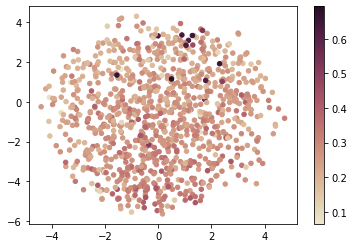

In [249]:
col = 'Diagnosis'
x1 = []
y1 = []
avgno_show = []
for index, value in enumerate(new_values):
    x1.append(new_values[index][0])
    y1.append(new_values[index][1])
    cnt = 0
    no_show = 0
    for col in range(0,maxlen):
        t = d_train_data_df[d_train_data_df[col] == index]
        cnt += len(t)  ##maybe double counting visits need to fix
        no_show += t['NoShow'].sum()
    avg = no_show/cnt
    avgno_show.append(avg)
    
f, ax = plt.subplots()

cmap = sns.cubehelix_palette(n_colors=10, start=0.3, rot=0.4, gamma=1.0, hue=1.0, light=0.9, dark=0.1, as_cmap=True)
axs0 = ax.scatter(x1, y1, s=20, c=avgno_show, cmap=cmap)
f.colorbar(axs0, ax=ax, orientation='vertical')


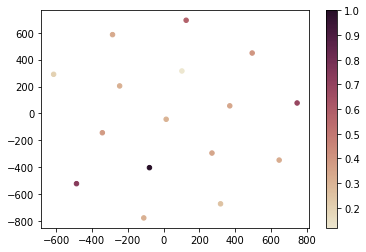

In [233]:
col = 'PostalCode'
full_train = x_train.merge(y_train, left_index=True, right_index=True)
x1 = []
y1 = []
avgno_show = []
for index, value in enumerate(new_values):
    avgno_show.append(full_train[full_train[col]==index]['NoShow'].mean())
    x1.append(new_values[index][0])
    y1.append(new_values[index][1])

f, ax = plt.subplots()

cmap = sns.cubehelix_palette(n_colors=10, start=0.3, rot=0.4, gamma=1.0, hue=1.0, light=0.9, dark=0.1, as_cmap=True)
axs0 = ax.scatter(x1, y1, s=20, c=avgno_show, cmap=cmap)
f.colorbar(axs0, ax=ax, orientation='vertical')

array(['Unseen'], dtype=object)